We are attempting to change the distance metric used by Kmeans from euclidean to other metrics.
Note that k-means is designed for Euclidean distance. It may stop converging with other distances, when the mean is no longer a best estimation for the cluster "center". By definition, the k-means clustering algorithm relies on the euclidean distance from the mean of each cluster. You could use a different metric, but you have to now update the cluster-center estimating function as well. I haven't seen a proof for convergence with Cosine. I believe it will converge if your data is non-negative and normalized to the unit sphere, because then it's essentially k-means in a different vector space.


Try https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9641480 K-cosine-means

https://www.youtube.com/watch?v=Axyi1rB8yGs Tells us that the key reason for metric to fail is the loss function. Euclidean distance (preserves triangle inequality, essentially) ensures that the loss function is guaranteed to reduce or stay equal when the new centroids are introduced compared to the previous cluster centers.

We can try to analytically & empirically prove that certain metrics can/can't be used.



In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=8, metric='euclidean', max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.metric = metric
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        self.centroids_ = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for i in range(self.max_iter):
            if self.metric == 'euclidean':
                distances = cdist(X, self.centroids_, metric='euclidean')
            elif self.metric == 'cosine':
                distances = 1 - cosine_similarity(X, self.centroids_)
            elif self.metric == 'dot':
                distances = -np.dot(X, self.centroids_.T)
            elif self.metric == 'manhattan':
                distances = cdist(X, self.centroids_, metric='cityblock')
            elif self.metric == 'jaccard':
                distances = cdist(X, self.centroids_, metric='jaccard')
            else:
                raise ValueError(f"Unsupported metric: {self.metric}")

            self.labels_ = np.argmin(distances, axis=1)
            new_centroids = np.array([X[self.labels_ == j].mean(axis=0) for j in range(self.n_clusters)])
            
            if np.all(self.centroids_ == new_centroids):
                break
            
            self.centroids_ = new_centroids
        
        return self

    def predict(self, X):
        if self.metric == 'euclidean':
            distances = cdist(X, self.centroids_, metric='euclidean')
        elif self.metric == 'cosine':
            distances = 1 - cosine_similarity(X, self.centroids_)
        elif self.metric == 'dot':
            distances = -np.dot(X, self.centroids_.T)
        elif self.metric == 'manhattan':
            distances = cdist(X, self.centroids_, metric='cityblock')
        elif self.metric == 'jaccard':
            distances = cdist(X, self.centroids_, metric='jaccard')
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

        return np.argmin(distances, axis=1)

# Example usage:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, centers=4, random_state=42)

# # Create a CustomKMeans instance with Euclidean distance
# kmeans = CustomKMeans(n_clusters=4, metric='euclidean', random_state=42)
# kmeans.fit(X)
# labels = kmeans.predict(X)

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3
3
3
2


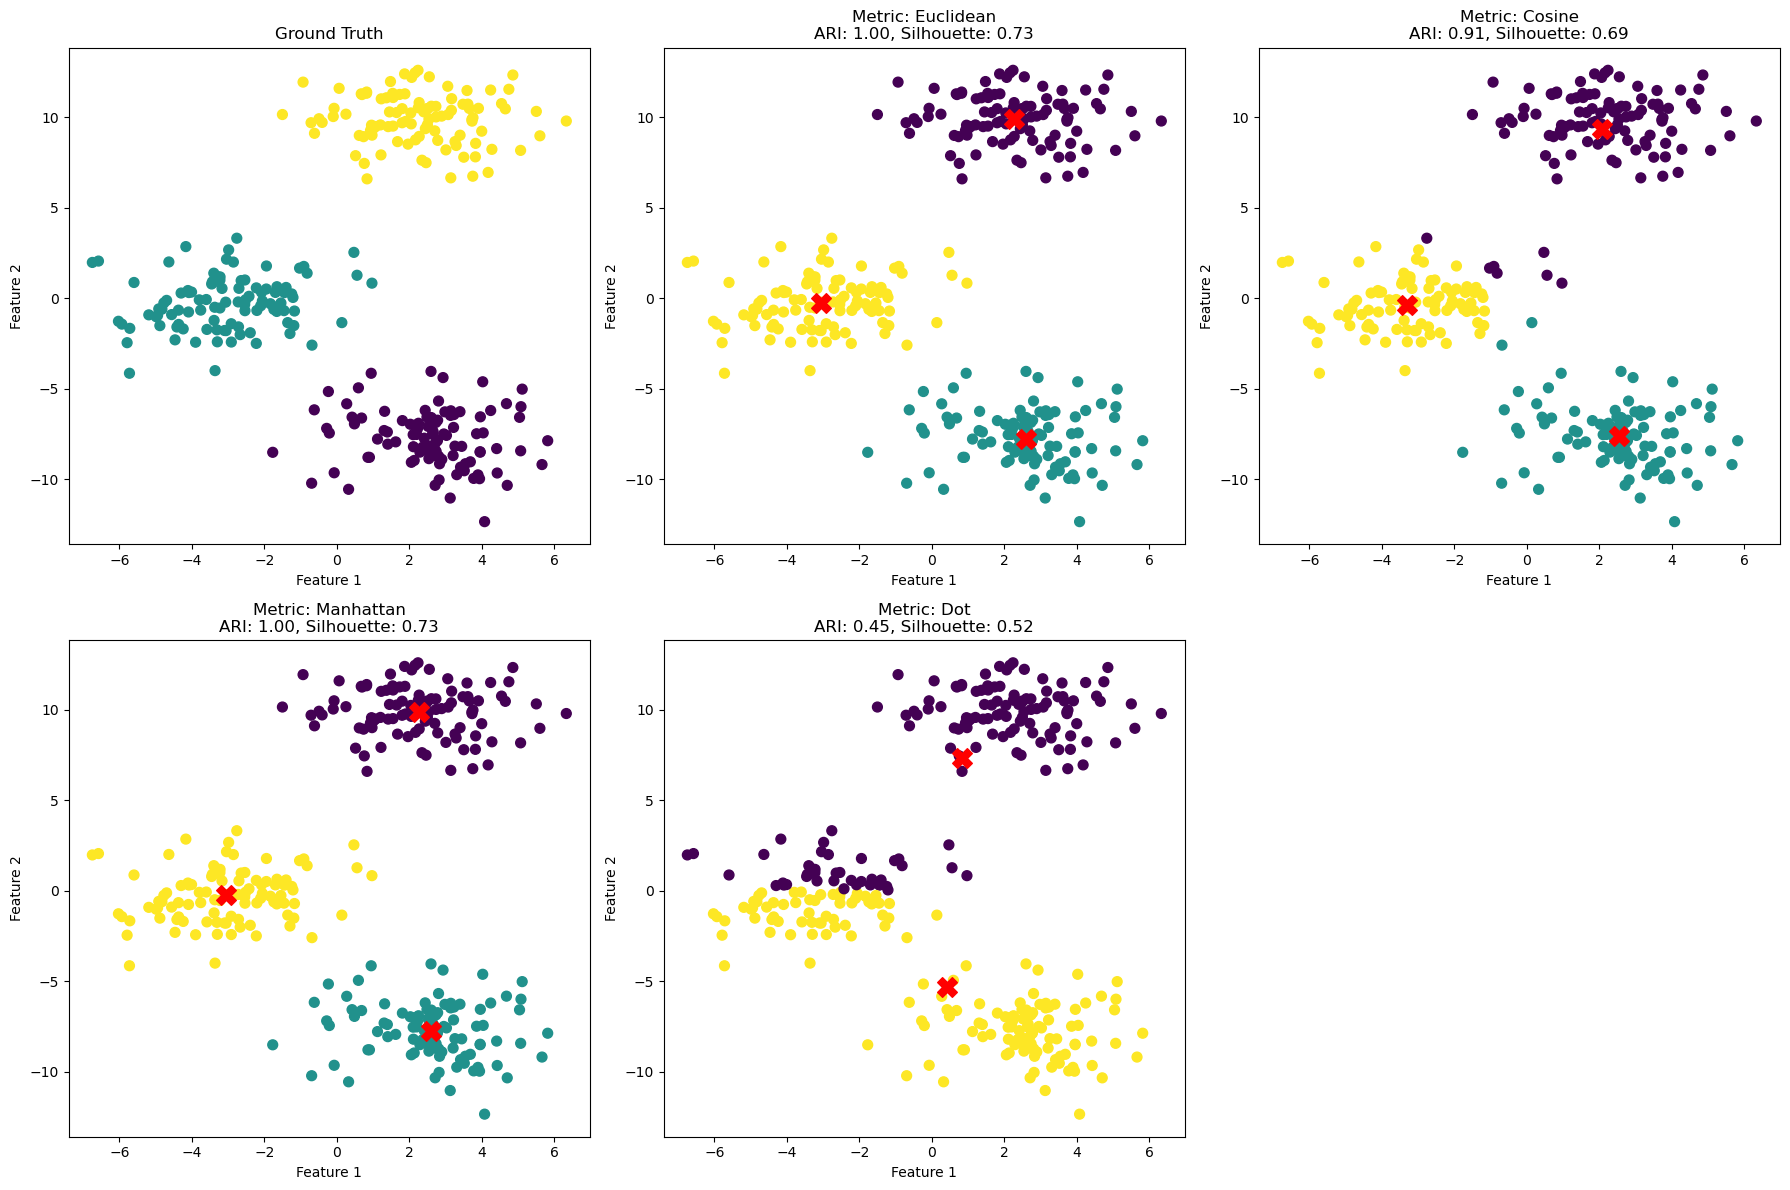

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Define a dictionary to store the different distance metrics
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def cosine_distance(point1, point2):
    return 1 - np.dot(point1, point2) / (np.linalg.norm(point1) * np.linalg.norm(point2))

def manhattan_distance(point1, point2):
    return np.sum(np.abs(np.array(point1) - np.array(point2)))

def dot_product_distance(point1, point2):
    return np.dot(point1, point2)

# Define the custom metrics
metrics = {
    'euclidean': distance_metric(type_metric.USER_DEFINED, func=euclidean_distance),
    'cosine': distance_metric(type_metric.USER_DEFINED, func=cosine_distance),
    'manhattan': distance_metric(type_metric.USER_DEFINED, func=manhattan_distance),
    'dot': distance_metric(type_metric.USER_DEFINED, func=dot_product_distance),
}

n_clusters = np.random.randint(3,10)

# Create a synthetic dataset with ground truth
X, y_true = make_blobs(n_samples=300, centers=n_clusters, cluster_std=1.5)

def initialize_centroids(X, n_clusters):
    """ Initialize centroids using k-means++ method """
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++').fit(X)
    return kmeans.cluster_centers_.tolist()

# Generate initial centroids using k-means++
start_centers = initialize_centroids(X, n_clusters)

# Create a figure for subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot the ground truth in the first subplot
axes[0].scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Run KMeans with different metrics and plot the results
for i, (metric_name, metric) in enumerate(metrics.items(), start=1):
    kinstance = kmeans(X.tolist(), start_centers, metric=metric)
    kinstance.process()
    clusters = kinstance.get_clusters()
    # Convert clusters to labels
    y_pred = np.zeros(X.shape[0])
    for cluster_id, cluster in enumerate(clusters):
        for point_id in cluster:
            y_pred[point_id] = cluster_id

    # Calculate performance metrics
    ari = adjusted_rand_score(y_true, y_pred)
    silhouette = silhouette_score(X, y_pred, metric='euclidean')

    # Plot the clusters
    axes[i].scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='viridis')
    centroids = np.array([X[cluster].mean(axis=0) for cluster in clusters])
    axes[i].scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X')
    print(len(centroids))
    
    # Set the title and performance metrics
    axes[i].set_title(f'Metric: {metric_name.capitalize()}\nARI: {ari:.2f}, Silhouette: {silhouette:.2f}')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

# Hide the last empty subplot if the number of metrics is less than the grid
if len(metrics) + 1 < len(axes):
    axes[-1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [4]:
# I think dot similarity metric has some errors that are handled weirdly and that's why they give fewer clusters
# Check if the code makes sense again.

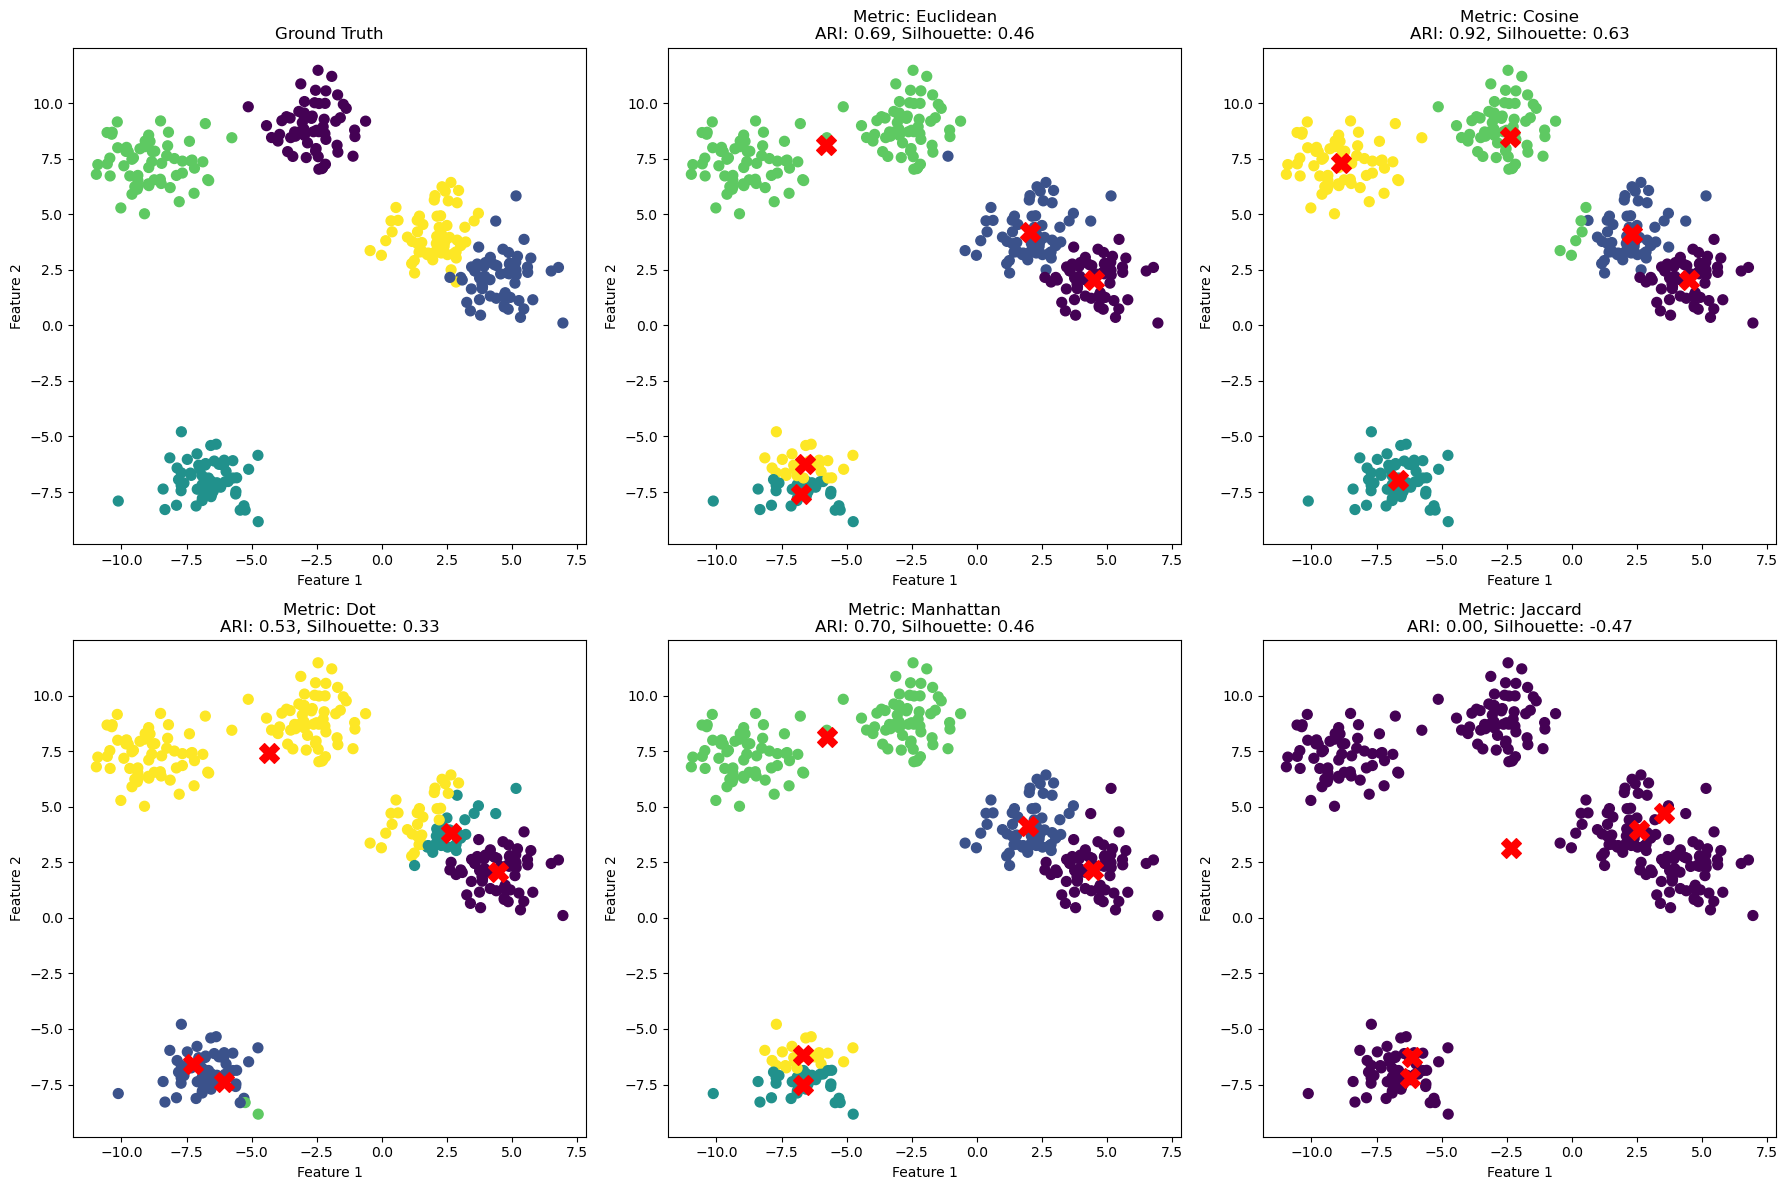

In [9]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

class CustomKMeans:
    def __init__(self, n_clusters=8, metric='euclidean', max_iter=800, random_state=42):
        self.n_clusters = n_clusters
        self.metric = metric
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        self.centroids_ = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for i in range(self.max_iter):
            if self.metric == 'euclidean':
                distances = cdist(X, self.centroids_, metric='euclidean')
            elif self.metric == 'cosine':
                distances = 1 - cosine_similarity(X, self.centroids_)
            elif self.metric == 'dot':
                distances = -np.dot(X, self.centroids_.T)
            elif self.metric == 'manhattan':
                distances = cdist(X, self.centroids_, metric='cityblock')
            elif self.metric == 'jaccard':
                distances = cdist(X, self.centroids_, metric='jaccard')
            else:
                raise ValueError(f"Unsupported metric: {self.metric}")

            self.labels_ = np.argmin(distances, axis=1)
            
            # Ensure no empty clusters
            new_centroids = []
            for j in range(self.n_clusters):
                points_in_cluster = X[self.labels_ == j]
                if points_in_cluster.size == 0:
                    # Reassign centroid to a random point
                    new_centroids.append(X[np.random.choice(X.shape[0])])
                else:
                    new_centroids.append(points_in_cluster.mean(axis=0))
            
            new_centroids = np.array(new_centroids)
            
            # Check for convergence
            if np.all(self.centroids_ == new_centroids):
                break
            
            self.centroids_ = new_centroids
        
        return self

    def predict(self, X):
        if self.metric == 'euclidean':
            distances = cdist(X, self.centroids_, metric='euclidean')
        elif self.metric == 'cosine':
            distances = 1 - cosine_similarity(X, self.centroids_)
        elif self.metric == 'dot':
            distances = -np.dot(X, self.centroids_.T)
        elif self.metric == 'manhattan':
            distances = cdist(X, self.centroids_, metric='cityblock')
        elif self.metric == 'jaccard':
            distances = cdist(X, self.centroids_, metric='jaccard')
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

        return np.argmin(distances, axis=1)

# Example usage:
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt

# Create synthetic dataset
n_clusters = 5
X, y_true = make_blobs(n_samples=300, centers=n_clusters, random_state=42)

# Initialize CustomKMeans with different metrics
metrics = ['euclidean', 'cosine', 'dot', 'manhattan', 'jaccard']
kmeans_models = {}

for metric in metrics:
    kmeans = CustomKMeans(n_clusters=n_clusters, metric=metric, random_state=42)
    kmeans.fit(X)
    kmeans_models[metric] = kmeans

# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Ground truth plot
axes[0].scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

for i, metric in enumerate(metrics):
    y_pred = kmeans_models[metric].predict(X)
    
    # Calculate performance metrics
    ari = adjusted_rand_score(y_true, y_pred)
    silhouette = silhouette_score(X, y_pred, metric='euclidean')
    
    axes[i+1].scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='viridis')
    axes[i+1].scatter(kmeans_models[metric].centroids_[:, 0], kmeans_models[metric].centroids_[:, 1], s=200, c='red', marker='X')
    axes[i+1].set_title(f'Metric: {metric.capitalize()}\nARI: {ari:.2f}, Silhouette: {silhouette:.2f}')
    axes[i+1].set_xlabel('Feature 1')
    axes[i+1].set_ylabel('Feature 2')

# Adjust layout
plt.tight_layout()
plt.show()


#### Maybe this is because the clusters are well separated. What if we try it using the embeddings and networks we have generated for studying Alt_Means on this. As the mixing rate of lfr nets increase, how does the performance of kmeans compared using the different metrics, change?